# Constructing Canonical Forcing Fields

In [11]:
# data handling
import numpy    as np
import xarray   as xr

# plotting
import matplotlib.pyplot as pyp
import cmocean

# helper functions
import utils

## Introduction

This notebook will cover the synthesizing of the following forcing fields:
1) A homogeneous current field,
2) A zonal current jet,
3) A mesoscale eddy,
4) A constant bathymetry field,
5) and an idealized island.

With bonus files for a sloped beach.

All fields will be steady (no variation in time), a core assumption of the ray tracing equations.

In [1]:
output_dir = './data/'

## Domain Parameters

For these synthesized datasets, we will be using a 100 km by 200 km domain with 1 km grid spacing. Mantaray expects the grid to be in units of meters.

In [4]:
# Parameters for the background domain [m]
Lx = 200_000 # x-length
Ly = 100_000 # y-length
dx = 1_000   # x grd spacing
dy = 1_000   # y grid spacing

In [5]:
# x/y grid
x = np.arange(0, Lx, dx)
y = np.arange(0, Ly, dy)
xv, yv = np.meshgrid(x, y)

## Currents

### No Currents

This field will have the same u/v velocity (0 m/s) at all grid points and will be used for examples where we are interested in studying how the waves respond to different depth fields.

In [6]:
# Choose a u/v current speed [m/s]
u = 0
v = 0

In [7]:
# grid u/v
U_homog = np.full_like(xv, u)
V_homog = np.full_like(yv, v)

In [8]:
# build into an xarray dataset
ds_homog = xr.Dataset(
    data_vars={
        "x": (["x"], x),
        "y": (["y"], y),
        "u": (["y", "x"], U_homog, {"long_name": "zonal current velocity", "units": "m/s"}),
        "v": (["y", "x"], V_homog, {"long_name": "meridional current velocity", "units": "m/s"}),
    }
)

Note: data must be saved using the `NETCDF3_CLASSIC` format.

In [9]:
ds_homog.to_netcdf(output_dir+'currents/homogeneous.nc', format="NETCDF3_CLASSIC")

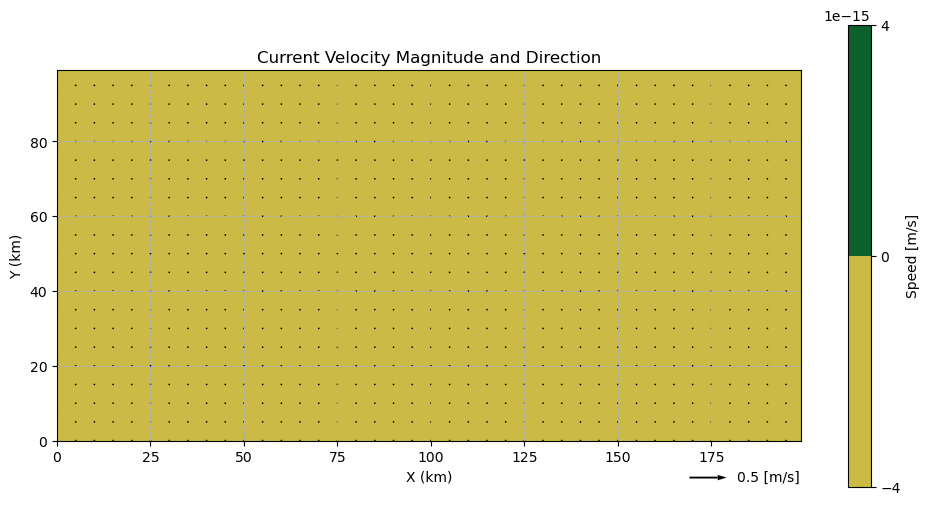

In [12]:
# Plot using helper function
utils.plot_current_field(xv, yv, ds_homog, skip=5, q_scale=0.1)

### Zonal Jet

This field will have a zonal current jet whose profile follows a Gaussian distribution:
$$
f(x) = A \cdot e^{-\frac{(x-\mu)^2}{2\sigma^2}}
$$

In [14]:
# Choose the maximum speed of the jet [m/s]
U_max = 0.3
width = 0.25 # controls how 'fat' the distribution (jet) is

In [15]:
x_profile = np.linspace(-1, 1, len(y))
U_profile = U_max * np.exp((-x_profile**2) / (2 * width**2))

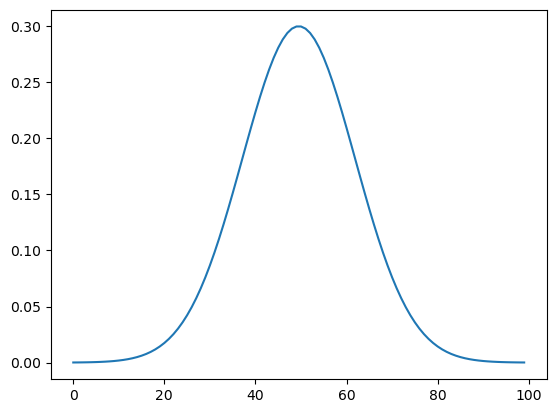

In [16]:
pyp.plot(U_profile)

We extend the profile along the x-axis and assume there is no zonal current.

In [17]:
U_jet = np.ones((len(y), len(x))) * U_profile[:, np.newaxis]
V_jet = np.zeros_like(U_jet)

In [18]:
ds_jet = xr.Dataset(
    data_vars={
        "x": (["x"], x),
        "y": (["y"], y),
        "u": (["y", "x"], U_jet, {"long_name": "zonal current velocity", "units": "m/s"}),
        "v": (["y", "x"], V_jet, {"long_name": "meridional current velocity", "units": "m/s"}),
    }
)

In [19]:
ds_jet.to_netcdf(output_dir+'currents/jet.nc', format="NETCDF3_CLASSIC")

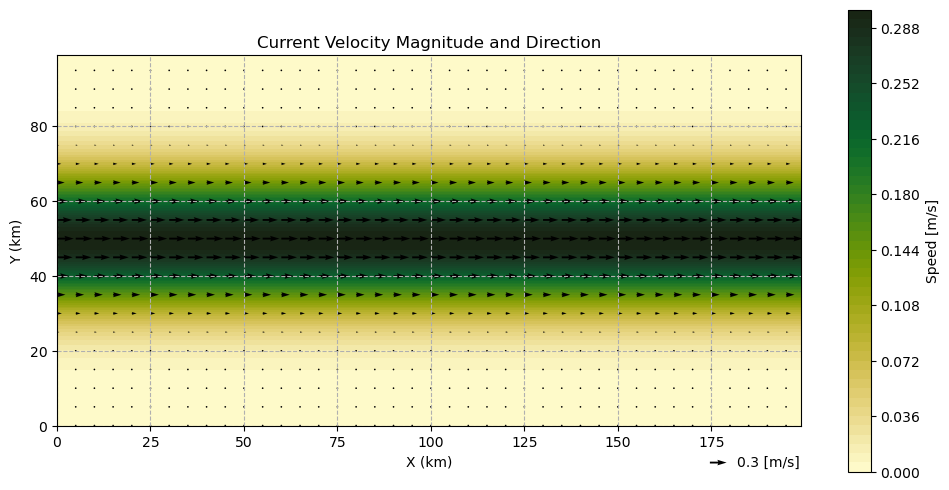

In [20]:
utils.plot_current_field(xv, yv, ds_jet, skip=5, q_ref=0.3, q_scale=0.075)

### Mesoscale Eddy

We will make a realistic mesoscale eddy (10's-100's of km across) and insert it into a larger static domain.

In [22]:
L_eddy = 75_000 # diameter of the eddy [m]

In [23]:
# Grid for smaller eddy domain
x_eddy = np.arange(0, L_eddy, dx)
y_eddy = np.arange(0, L_eddy, dy)
xv_eddy, yv_eddy = np.meshgrid(x_eddy, y_eddy)

We set the maximum speed of the Eddy to be 1 m/s to make it's impact on rays more dramatic.

In [24]:
U_max = 1 # [m/s]

The velocity field is constructed such that eddy is ring-shaped.

In [25]:
# Eddy velocity field
u_eddy = U_max  * np.sin(np.pi * xv_eddy / L_eddy) * np.cos(np.pi * yv_eddy / L_eddy)
v_eddy = -U_max * np.cos(np.pi * xv_eddy / L_eddy) * np.sin(np.pi * yv_eddy / L_eddy)

We now insert the eddy into a larger domain. We define the center of the eddy using the units of the domain.

In [26]:
# Define the center of the eddy [m]
center_x = 75_000
center_y = 50_000

In [27]:
# Create static background velocity field
u_background = np.zeros_like(xv).astype(float)
v_background = np.zeros_like(yv).astype(float)

idx_center_x = int((center_x - L_eddy/2) / dx)
idx_center_y = int((center_y - L_eddy/2) / dy)

# Insert the tapered eddy
u_background[idx_center_y:idx_center_y + len(y_eddy), 
             idx_center_x:idx_center_x + len(x_eddy)] += u_eddy
v_background[idx_center_y:idx_center_y + len(y_eddy), 
             idx_center_x:idx_center_x + len(x_eddy)] += v_eddy

In [28]:
ds_eddy = xr.Dataset(
    data_vars={
        "x": (["x"], x),
        "y": (["y"], y),
        "u": (["y", "x"], u_background, {"long_name": "zonal current velocity", "units": "m/s"}),
        "v": (["y", "x"], v_background, {"long_name": "meridional current velocity", "units": "m/s"}),
    }
)

In [29]:
ds_eddy.to_netcdf(output_dir+'currents/eddy.nc', format="NETCDF3_CLASSIC")

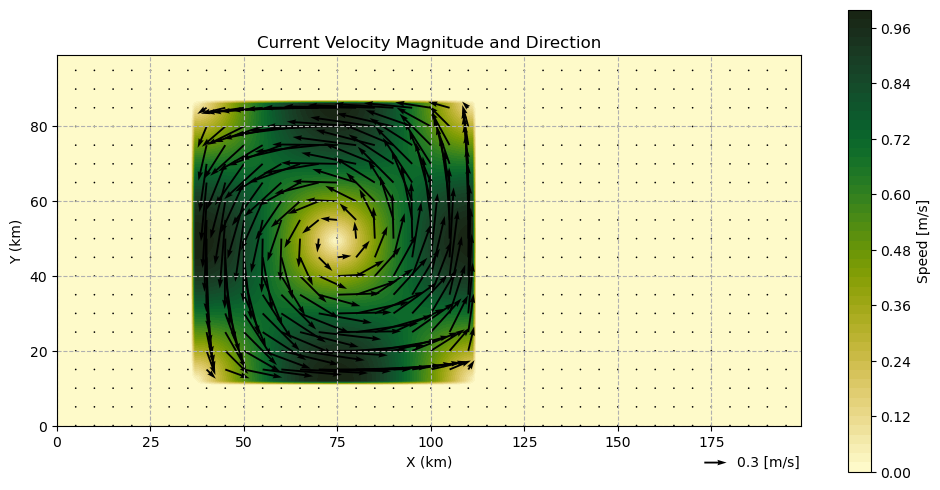

In [30]:
utils.plot_current_field(xv, yv, ds_eddy, skip=5, q_ref=0.3, q_scale=0.1)

## Bathymetry

### Constant Bathymetry

For the different current examples, we will use a constant deep bathymetry field.

In [38]:
bathy_const = np.full_like(xv, 4000) # [m]

In [39]:
ds_const = xr.Dataset(
    data_vars={
        "x": (["x"], x),
        "y": (["y"], y),
        "depth": (["y", "x"], bathy_const, {"long_name": "bathymetry", "units": "m"})
    }
)

In [40]:
ds_const.to_netcdf(output_dir+'bathymetry/constant.nc', format="NETCDF3_CLASSIC")

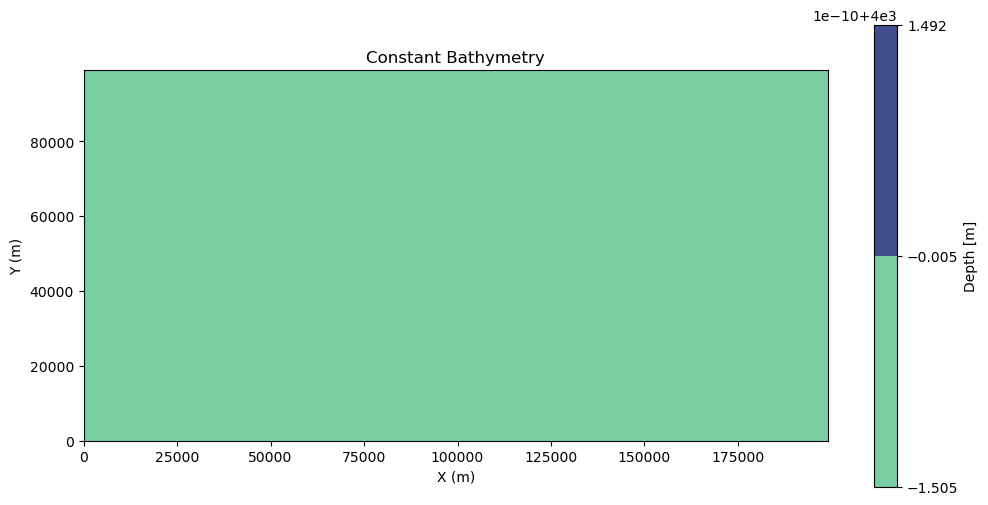

In [41]:
fig, ax = pyp.subplots(figsize=(12, 6))

c = ax.contourf(xv, yv, bathy_const, cmap=cmocean.cm.deep)

fig.colorbar(c, ax=ax, label='Depth [m]')

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')

ax.set_title('Constant Bathymetry')

ax.set_aspect('equal')

pyp.show()

## Gaussian Island

We will also show an example of no currents but with an island sea mound.

In [42]:
# Island parameters [m]
L_mound      = 1e5 # diameter of the sea mound
H_background = 100 # background depth
elevation    = 50  # maximum height of the island (above sea level)

In [43]:
x_mound = np.arange(-L_mound/2, L_mound/2, dx)  # x-axis values (symmetrical about 0)
y_mound = np.arange(-L_mound/2, L_mound/2, dy)  # y-axis values (symmetrical about 0)
xv_mound, yv_mound = np.meshgrid(x_mound, y_mound)  

In [44]:
R = np.sqrt(xv_mound**2 + yv_mound**2)

# Normalize the radial distance to range from 0 to L_x/2 (maximum radial distance)
R_normalized = np.clip(R / (L_mound / 2), 0, 1)  # Normalize radius, clip to [0, 1]

# Use sin^2 function to create the profile, with peak at sin^2(pi/2)
mound = (H_background+elevation) * np.sin(np.pi * R_normalized / 2 + np.pi/2)**2

In [45]:
# Define island center in the larger bathymetry field
center_x = 100000  # meters
center_y = 50000   # meters

In [50]:
idx_center_x = int((center_x - L_mound / 2) / dx)
idx_center_y = int((center_y - L_mound / 2) / dy)

bathy_const = np.full_like(xv, H_background).astype(float)

# Subtract the island bump from the bathymetry field
bathy_island = bathy_const.copy()
bathy_island[idx_center_y:idx_center_y + len(y_mound), 
             idx_center_x:idx_center_x + len(x_mound)] -= mound

In [51]:
ds_island = xr.Dataset(
    data_vars={
        "x": (["x"], x),
        "y": (["y"], y),
        "depth": (["y", "x"], bathy_island, {"long_name": "bathymetry", "units": "m"})
    }
)

In [52]:
ds_island.to_netcdf(output_dir+'bathymetry/island.nc', format="NETCDF3_CLASSIC")

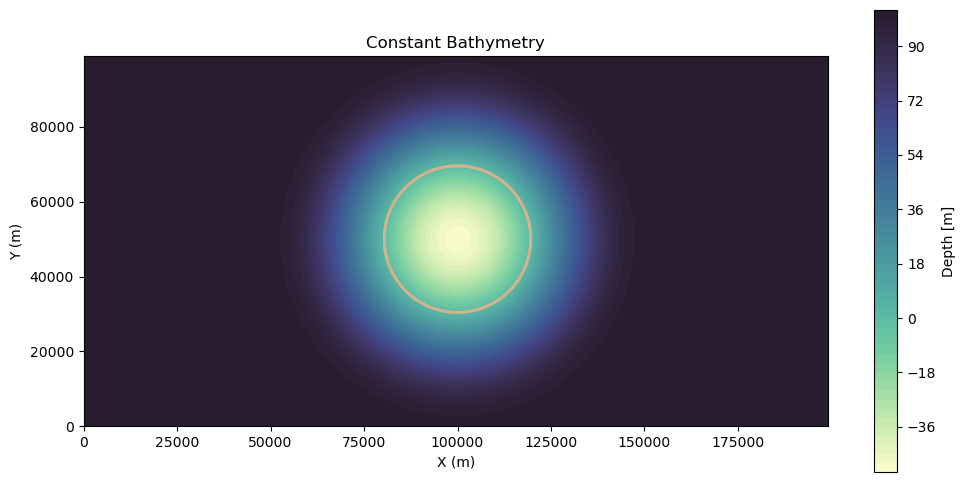

In [53]:
fig, ax = pyp.subplots(figsize=(12, 6))

c = ax.contourf(xv, yv, bathy_island, cmap=cmocean.cm.deep, levels=50)

is_contour = ax.contour(xv, yv, bathy_island, levels=[0], colors='tan', linewidths=2)
is_contour = ax.contour(xv, yv, bathy_island, levels=[0], colors='tan', linewidths=2)


fig.colorbar(c, ax=ax, label='Depth [m]')

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')

ax.set_title('Constant Bathymetry')

ax.set_aspect('equal')

pyp.show()

Note: following convention, more positive depth is deeper, while more negative depth is above sea level.

### BONUS: A Gentle Beach

We will construct a bathymetry field that linearly increases in depth along the y-axis.

In [55]:
bathy_beach = np.tile(np.linspace(250, -10, yv.shape[0])[:, np.newaxis], (1, yv.shape[1]))

In [56]:
ds_beach = xr.Dataset(
    data_vars={
        "x": (["x"], x),
        "y": (["y"], y),
        "depth": (["y", "x"], bathy_beach, {"long_name": "bathymetry", "units": "m"})
    }
)

In [57]:
ds_beach.to_netcdf(output_dir+'bathymetry/beach.nc', format="NETCDF3_CLASSIC")

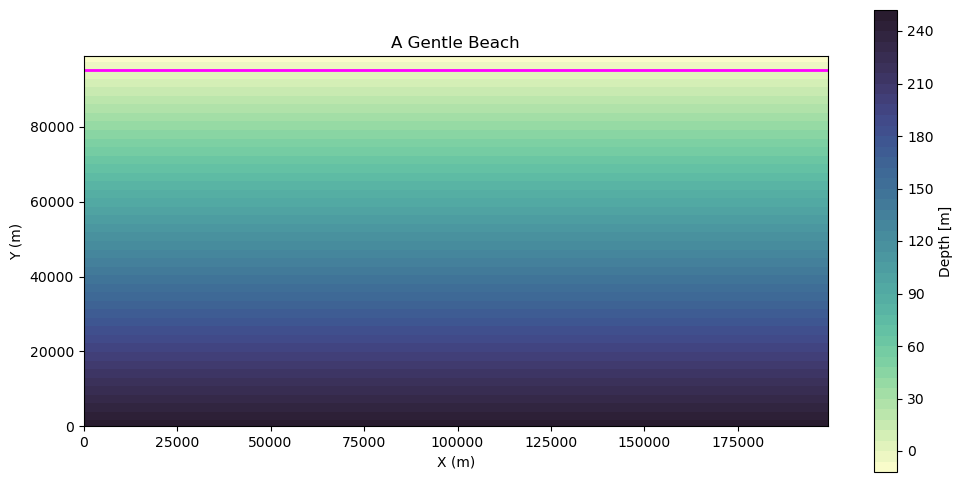

In [59]:
fig, ax = pyp.subplots(figsize=(12, 6))

# Filled contour plot
c = ax.contourf(xv, yv, bathy_beach, cmap=cmocean.cm.deep, levels=50)

# Add contour line at 0 depth
zero_contour = ax.contour(xv, yv, bathy_beach, levels=[0], colors='magenta', linewidths=2)

fig.colorbar(c, ax=ax, label='Depth [m]')

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('A Gentle Beach')

ax.set_aspect('equal')

pyp.show()

# New Eddy

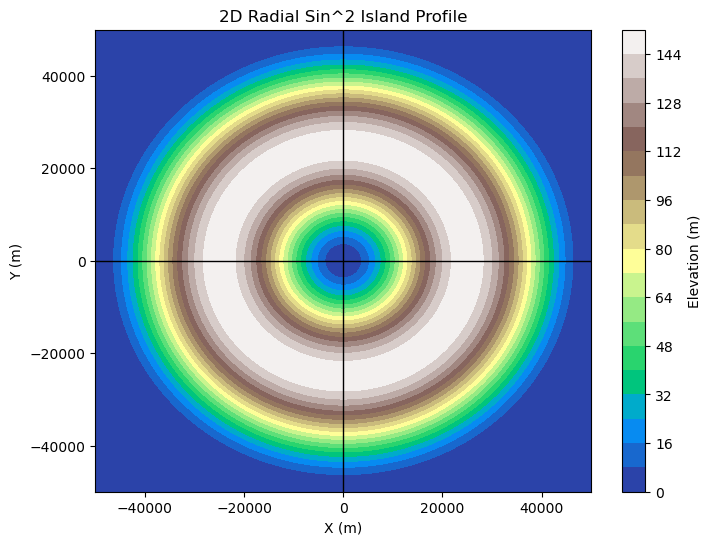

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
z_max = 150  # Maximum elevation (m)
L_x = 1e5    # Grid size in the x-direction (100 km)
L_y = 1e5    # Grid size in the y-direction (100 km)

# Create a grid of x, y values
x = np.linspace(-L_x/2, L_x/2, 200)  # x-axis values (symmetrical about 0)
y = np.linspace(-L_y/2, L_y/2, 200)  # y-axis values (symmetrical about 0)
X, Y = np.meshgrid(x, y)              # 2D grid

# Calculate the radial distance from the center
R = np.sqrt(X**2 + Y**2)

# Create the 1D sin^2 profile for radial distances from 0 to L_x/2
radii = np.linspace(0, L_x/2, 200)
z_profile = z_max * np.sin(np.pi * radii / (L_x / 2))**2  # sin^2 function from 0 to L_x/2

# Interpolate the 1D profile to match the radial distances
Z = np.interp(R.flatten(), radii, z_profile)  # Interpolate 1D profile onto 2D grid
Z = Z.reshape(X.shape)  # Reshape back to 2D grid

# Plot the 2D profile
plt.figure(figsize=(8,6))
cp = plt.contourf(X, Y, Z, 20, cmap='terrain')
plt.colorbar(cp, label="Elevation (m)")
plt.title("2D Radial Sin^2 Island Profile")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.show()


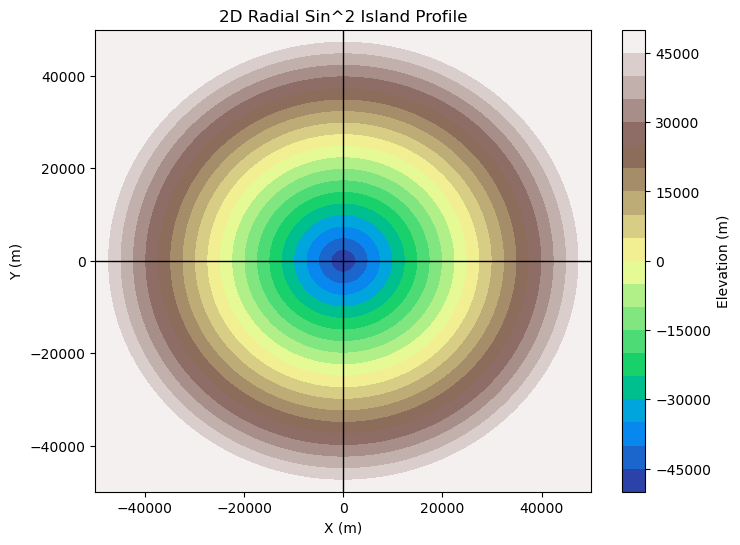

In [448]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
z_max = 150  # Maximum elevation (m)
L_x = 1e5    # Grid size in the x-direction (100 km)
L_y = 1e5    # Grid size in the y-direction (100 km)

# Create a grid of x, y values
x = np.linspace(-L_x/2, L_x/2, 200)  # x-axis values (symmetrical about 0)
y = np.linspace(-L_y/2, L_y/2, 200)  # y-axis values (symmetrical about 0)
X, Y = np.meshgrid(x, y)              # 2D grid

# Calculate the radial distance from the center
R = np.sqrt(X**2 + Y**2)

# Create the 1D sin^2 profile for radial distances from 0 to L_x/2
radii = np.linspace(0, L_x/2, 200)
z_profile = z_max * np.sin(np.pi * radii / (L_x / 2))**2  # sin^2 function from 0 to L_x/2

# Interpolate the 1D profile to match the radial distances
Z = np.interp(R.flatten(), radii, y)  # Interpolate 1D profile onto 2D grid
Z = Z.reshape(X.shape)  # Reshape back to 2D grid

# Plot the 2D profile
plt.figure(figsize=(8,6))
cp = plt.contourf(X, Y, Z, 20, cmap='terrain')
plt.colorbar(cp, label="Elevation (m)")
plt.title("2D Radial Sin^2 Island Profile")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.show()


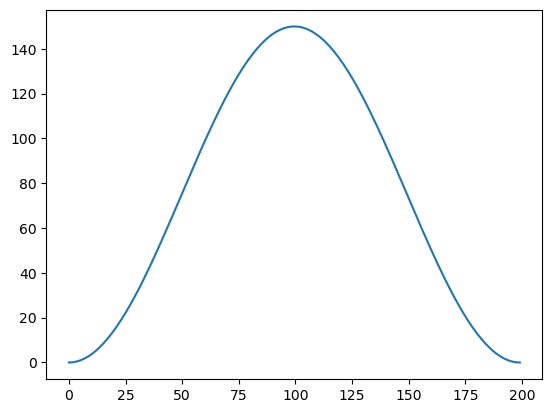

In [438]:
pyp.plot(z_profile)

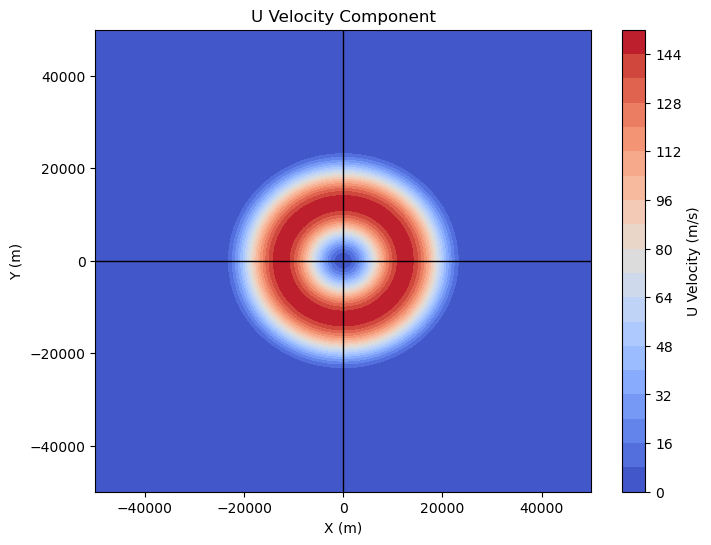

In [354]:
# Define a radial unit vector field
theta = np.arctan2(Y, X)  # Angle at each grid point

# Scale velocity by Z (stronger in the middle, weaker at edges)
U = Z * np.cos(theta)
V = Z * np.sin(theta)

plt.figure(figsize=(8,6))
plt.contourf(X, Y, np.sqrt(U**2+V**2), 20, cmap='coolwarm')  # Contour plot of U
plt.colorbar(label="U Velocity (m/s)")
plt.title("U Velocity Component")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.show()



In [61]:
z_profile = z_max * np.sin(np.pi * radii / (L_x / 2))**2  # sin^2 function from 0 to L_x/2

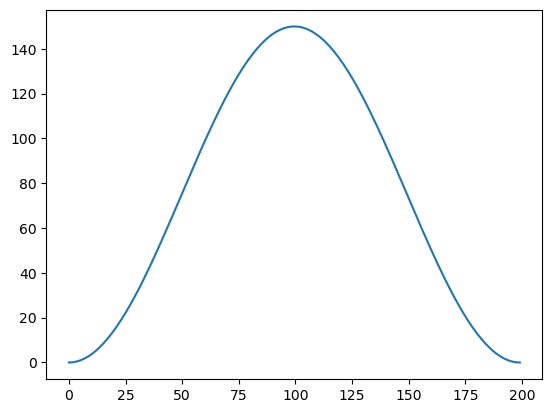

In [62]:
plt.plot(z_profile)

In [449]:
L_x

100000.0

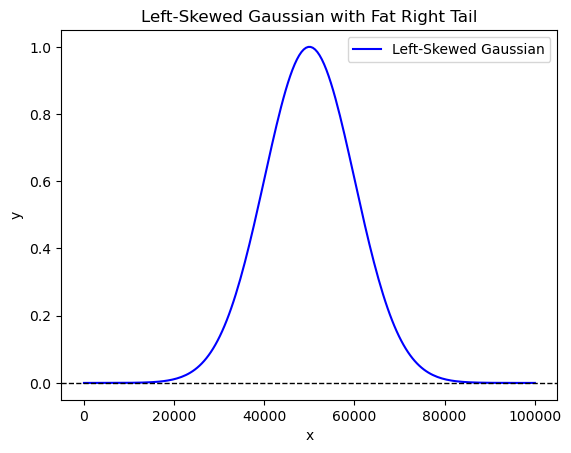

In [463]:
import numpy as np
import matplotlib.pyplot as plt

# Define x range
x = np.linspace(0, L_x, 200)

# Parameters to adjust shape
a = 3      # Controls left skew & fat tail
sigma = L_x / 10  # Width of Gaussian

# Compute function
y = (1 - np.exp(-a * radii)) * np.exp(-(x-L_x/2)**2 / (2 * sigma**2))

# Plot
plt.plot(x, y, label="Left-Skewed Gaussian", color="b")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Left-Skewed Gaussian with Fat Right Tail")
plt.axhline(0, color='black', linewidth=1, linestyle="--")
plt.legend()
plt.show()


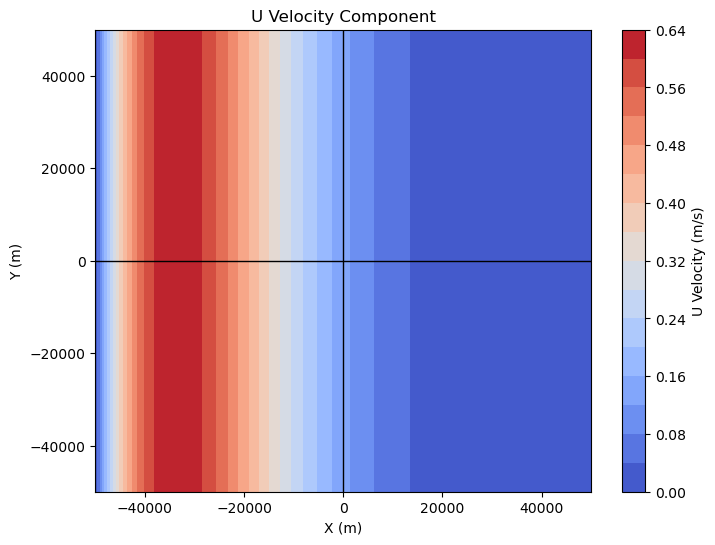

In [418]:
# Define a radial unit vector field
theta = np.arctan2(Y, X)  # Angle at each grid point

# Scale velocity by Z (stronger in the middle, weaker at edges)
U = y * np.cos(theta)
V = y * np.sin(theta)

plt.figure(figsize=(8,6))
plt.contourf(X, Y, np.sqrt(U**2+V**2), 20, cmap='coolwarm')  # Contour plot of U
plt.colorbar(label="U Velocity (m/s)")
plt.title("U Velocity Component")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.show()

